# What is the fishing effort in the Firth of Clyde?

## 1. Introduction

Fisheries in Scotland, as meassured by boats that fished within its EEZ regardless the landing happening through Scottish ports, is estimated to be around 490k tons a year from 2016 to 2018, reflecting a decrease in 7% from previous periods [1]. Only in Scotish ports, approximately 30% of all total landings were shellfish (147.5k tons), mainly composed of nephropds (43%), scallops (13.6%), edible crabs (12.4%) andlobsters (11.7%) [2].

The Firth of Clyde Scotland Marine Region (Clyde SMR) has an area of 4,279km<sup>2</sup> in the south west coast of Scotland, north to Solway and south to Argyll (Fig. 1). It is rather shallow with an average depth of 58m due to a sill running across the entry of the Firth Clyde, south of the region. To the north there are various estuaries such as River Clyde, Loch Fyne and Loch Long. The sill creates a front that provides that makes tidal currents weak, while the runoffs from the north of the region supply sediments that tend to remain within it, given the soft hydrodynamic conditions. Additionally the overall salinity is the lowest of all SMRs in Scotland, with strong vertical stratification due to the lighter weight of incoming freshwaters [3]. 

Clyde SMR seabed habitats are mainly formed by sublitoral mud, sandy mud and mud (Fig. 2)[5]. Burrowed mud is a well suitable habitat for some nephropds such as the Norway lobster (*Nephrops norvegicus*), which in turn helps the layers underneath the surfice to become anoxic [6]. Albeit, recent studies have shown the distribution of the Norway lobster throughout the Firth of Clyde (Fig. 1), matching very well with the seabed habitat mapping (Fig. 2) [4]. 

Other important biogenic habitats such as maerl (_Phymatolithon calcareum, Lithothamnion glaciale_) beds have been found to the north of the region within the Loch Fayne and to the south within the South Arran MPA [3]. Maerl beds are of tremendous importance for another precious fished species such as scallops, as juvenile individuals seek shelter within it as their nutural nursery [7]. Other important habitat-building species are flame shell (_Limaria hians_), believed to be clinical for scallop spats to attach to them as they fall from plankton [8]. 

This study examines the apparent fishing effort and the type of fishing gears used within the Clyde SMR, mainly for Firth of Clyde as most of the fishing industry in this area focuses on shellfish fisheries, where it is estimated that up to 4.8K tons were taken from this region alone in 2018. Norway lobsters and scallops are the main fished species requiring very disruptive fishing gears such as bottom-trawling for the former and dredging for the latter. Bottom-trawling is known to cause surface and subsurface (>3cm) abrasion as the doors are very heavy and are dragged along the haul distance [3]. Dredging on scallops on the other hand, may destroy biogenic habitas, such those formed by maerl beds, which take many decades to regenerate because they reproduce vegetatively from existing living parts and grow very slow [3,7].

<img src='../images/introduction_study_map_2.png'/>

**Fig. 1. Study area within the Clyde SMR (Estuaries Loch Fyne, Loch Long and River clyde to the north; A sill running across the Firth of Clyde to the south)**. Areas in red represent the existing Marine Protected Areas (MPAs) within the region. Green dots shows the habitat distribution of Norway Lobster (*Nephrops norvegicus*)[4]. The thick green rectangle shows the study area where fishing effort was measured.

<img src='../images/habitat-mapping.jpg' align="center"/>

**Fig. 2. "Fig 3.2 BGS DigSBS250 Dataset classified on the Rock_D variable (BGS DigSBS250 Dataset,2007)"** [5]. Seabed habitat classification of the Firth of Clyde. Yellowish colours are sand sediments while orangish ones represent muds. Most of the seabed is muddy sand, muddy gravel and sandy mud with sand following.  

 ## 2.Data and Methods
 
Apparent fishing effort details were fetched from querying the REST API available by Global Fishing Watch (GFW). The data compiled by GFW is based on vessels above 12 metres that have on board a Automatic Identification System (AIS). When their web was last updated in March 2021 more than 117k vessels were identified worldwide, from which 70K seems to be active every year [9,10].

The data was fetched in batch calls to the API at low resolution of 0.1 x 0.1 degrees (WS84 ESP: 4386). The total searched area of data, 1 x 1 degree or its equivalent in square kilometers at those latitudes to 124 x 62.4 = 7,737km2, was sent to the GFW API in geojson format(Fig. 1). It was made large enough to ensure all 0.1 x 0.1 rectangles composing the Firth of Clyde area were examined in the analysis. Therefore, each rectangle within the studied area has approximately an area of 77.4 km2. Details for a total of 90 rectangles were returned from the API. The remaining 10 were either entirely embeded within land or the marine area cover was not fished.

Different fishing effort vectors for trawling and dredging were generated for different periods: the whole time series, 2012 to 2015, 2015 to 2021 and 2022 alone. The motivation for such fragmention was that the South Arran MPA implemented a gradual fishing ban policy since 2016, mainly for trawling and dredging. However only full maps were built for the overall period.

The analysis and the construction of different shapefiles were done in Python 3.9, Pandas, Geopandas and Shaply. Seaborn and Matplotlib was used for the visualisation and QGIS 3.16 for the spatial analysis and map creation. All GIS map were created from the scratch with the exception of the Scotland polygon map [11], the MPA polygon map [12] and the nephrops distribution.

## 3.Results

Results are commented inline as they are produced through the sections of the notebook below.

In [237]:
import os
import requests
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import geopandas as gpd

from pathlib import Path
from dotenv import load_dotenv
from os.path import join
from typing import List, Dict
from datetime import datetime, timezone


path = Path(__file__).resolve()
ROOT_PATH = path.parents[1]

# Basic paths to key folders
SRC_PATH = ROOT_PATH / 'src'
DATA_PATH = ROOT_PATH / 'data'
FIRTH_DATA_PATH = DATA_PATH / 'firth_clyde_fishing_effort'

load_dotenv(join(SRC_PATH, '.env'))

True

In [576]:
API_URL = 'https://gateway.api.globalfishingwatch.org/v2/4wings/report'
API_TOKEN =  os.getenv('GFW_TOKEN')
API_HEADERS = {
    'Authorization': f'Bearer {API_TOKEN}',
}

#'2021-01-01T00:00:00.000Z,2022-01-01T00:00:00.000Z'
API_PARAMS = {
    'spatial-resolution': 'low',
    'temporal-resolution': 'yearly',
    'group-by': 'gearType',
    'datasets[0]': 'public-global-fishing-effort:latest',
    'date-range': None,
    'format': 'json'
}
API_DATA = {'geojson': {
    'type': 'Polygon',
    'coordinates': [[
    [-5.6115,55.0049],# bottom-left; polygon formed counter-clock wise
    [-4.6104,55.0049],
    [-4.6104,56.0994],
    [-5.6115,56.0994],
    [-5.6115,55.0049],
    ]]
}}
REQUESTED_YEARS = [2012 + x for x in range(11)]
CELL_SIZE_DEGREE = 0.1

In [585]:
# utils module used for various operations
def build_data_range(years: List[int]) -> List[str]:
    data = []
    for year in years:
        start_date = datetime(year, 1, 1, 0, 0, 0, tzinfo=timezone.utc).isoformat().replace("+00:00", "Z")
        end_date = datetime(year + 1, 1, 1, 0, 0, 0, tzinfo=timezone.utc).isoformat().replace("+00:00", "Z")
        data.append(f"{start_date},{end_date}")
    return data

def build_multiple_request_parameters (api_url: str, 
                                       api_headers: Dict, 
                                       api_params: Dict, 
                                       api_data: Dict, 
                                       years: List[int]) -> List[Dict]:
    data = []
    date_range = build_data_range (years)
    for period in date_range:
        params = dict(api_params)
        params['date-range'] = period
        data.append({
            'url' : api_url,
            'headers': api_headers,
            'params': params,
            'json': api_data
        })
    return data

def fetch_data_from_api (api_context: List[Dict]) -> List[Dict]:
    fishing_effort_data = []
    with requests.Session() as r_s:
        for context in api_context:
            r = r_s.post(**context)
            fishing_effort_data.append(r.json())
    return fishing_effort_data

def concatenate_time_series(api_results: List[Dict]) -> pd.DataFrame:
    return pd.concat([
        pd.DataFrame.from_records (record['entries'][0]['public-global-fishing-effort:v20201001']) 
        for record in api_results
    ])

def create_total_fishing_effort (data: pd.DataFrame, gear_type: str) -> pd.DataFrame:
    df_total = data.loc [(data['geartype'] == gear_type) & (data['hours'] > 0)]
    df_total = df_total[['lon', 'lat', 'hours', 'cell']]
    df_total = df_total.rename(columns={'lon': 'x', 'lat': 'y'})
    df_total = (df_total.groupby(['x', 'y', 'cell']).agg({'hours': 'sum'})).reset_index()
    assert round(df_total['hours'].sum()) == round(data.loc[data['geartype'] == gear_type, 'hours'].sum())
    df_total = df_total.round({'hours': 0})
    return df_total

def build_polygon_vector (data: pd.DataFrame, degree_offset: float) -> gpd.GeoDataFrame:
    gdf_total = gpd.GeoDataFrame(data, geometry= gpd.points_from_xy(data.x, data.y))
    gdf_total['geometry'] =gdf_total.apply(
        lambda s: shapely.geometry.Polygon(
            [
                [s['x'], s['y']],
                [s['x'] + degree_offset, s['y']],
                [s['x'] + degree_offset, s['y'] + degree_offset],
                [s['x'], s['y'] + degree_offset],
            ]),
        axis=1,
    )
    gdf_total =gdf_total.drop(columns=['x', 'y'])
    return gdf_total

def draw_polygon_ids (df: pd.DataFrame, ax):
    df.apply(lambda x: ax.annotate(text=x['cell'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [36]:
years = [2012 + x for x in range(11)]
api_context = build_multiple_request_parameters(API_URL, API_HEADERS, API_PARAMS, API_DATA, REQUESTED_YEARS)

In [316]:
# Just run the first time to fetch data from api.
is_data_downloaded = (FIRTH_DATA_PATH / 'fishing_effort_firth_2012_2022.csv').is_file()
if not is_data_downloaded:
    fishing_effort_data = fetch_data_from_api (api_context)
else:
    print("skipping api request: file exists")

skipping api request: file exists


In [32]:
timeseries = concatenate_time_series (fishing_effort_data)

In [317]:
if not is_data_downloaded:
    timeseries.to_csv(FIRTH_DATA_PATH / 'fishing_effort_firth_2012_2022.csv', index=False)
else:
    print("skipping csv writing: file exists")

skipping csv writing: file exists


### 3.1 Fishing gear types and use

From all fishing gears trawling is by far the most widely used method with 93% of the total effort, followed by gillnets. By contrast, dredging is only used 0.4% of the time as shown by the results and barplot below (left). The fishing effort all across the different gear types seems to remain constant throughout the timeseries with dredging increasing more substantially than any other from 2020. In 2020 all efforts went down slightly, most likely due to COVID restrictions imposed back then (right plot below). Fixed gears and pots and traps, are the ones with the shortest timeseries, with the latter having only isolated records for 2014 and 2020.

In [598]:
# create dataset for a stacked barplot
stack_barplot_df = timeseries[['date', 'geartype', 'hours']]
stack_barplot_df = stack_barplot_df.assign (geartype=(stack_barplot_df['geartype'].replace("_", " ", regex=True)).str.title())
stack_barplot_df = stack_barplot_df.groupby(['date', 'geartype']).agg({'hours': 'sum'}).reset_index()

# Create dataset for lineplot
scatter_line_plot_df = stack_barplot_df.copy()
scatter_line_plot_df.loc[scatter_line_plot_df["hours"] <= 0, "hours"] = 10 ** -10
scatter_line_plot_df = scatter_line_plot_df.assign (hours=np.log(scatter_line_plot_df["hours"]))

# Pivot the stacked barplot
stack_barplot_df = pd.pivot(stack_barplot_df, index='date', columns="geartype", values="hours").fillna(0)

# Create dataset to calculate annual average percentage of total effort by gear 
average_effort_pie_df = stack_barplot_df.copy()
average_effort_pie_df = average_effort_pie_df.div(average_effort_pie_df.sum(axis=1), axis=0)
average_effort_series = average_effort_pie_df.mean(axis=0)
average_effort_pie_df = pd.DataFrame ({'Fishing Gear': average_effort_series.index, 
                                       'Average (%)': np.round(average_effort_series.values, 4) * 100})

geartype
Dredge Fishing        0.003994
Fishing               0.027757
Fixed Gear            0.000132
Other Purse Seines    0.000040
Pots And Traps        0.000076
Set Gillnets          0.038742
Set Longlines         0.000096
Trawlers              0.929163
dtype: float64

In [592]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [593]:
average_effort_pie_df

,Fishing Gear,Average (%)
0,Dredge Fishing,0.40
1,Fishing,2.78
2,Fixed Gear,0.01
3,Other Purse Seines,0.00
4,Pots And Traps,0.01
5,Set Gillnets,3.87
6,Set Longlines,0.01
7,Trawlers,92.92


Text(0, 0.5, 'Logarithm (number of hours)')

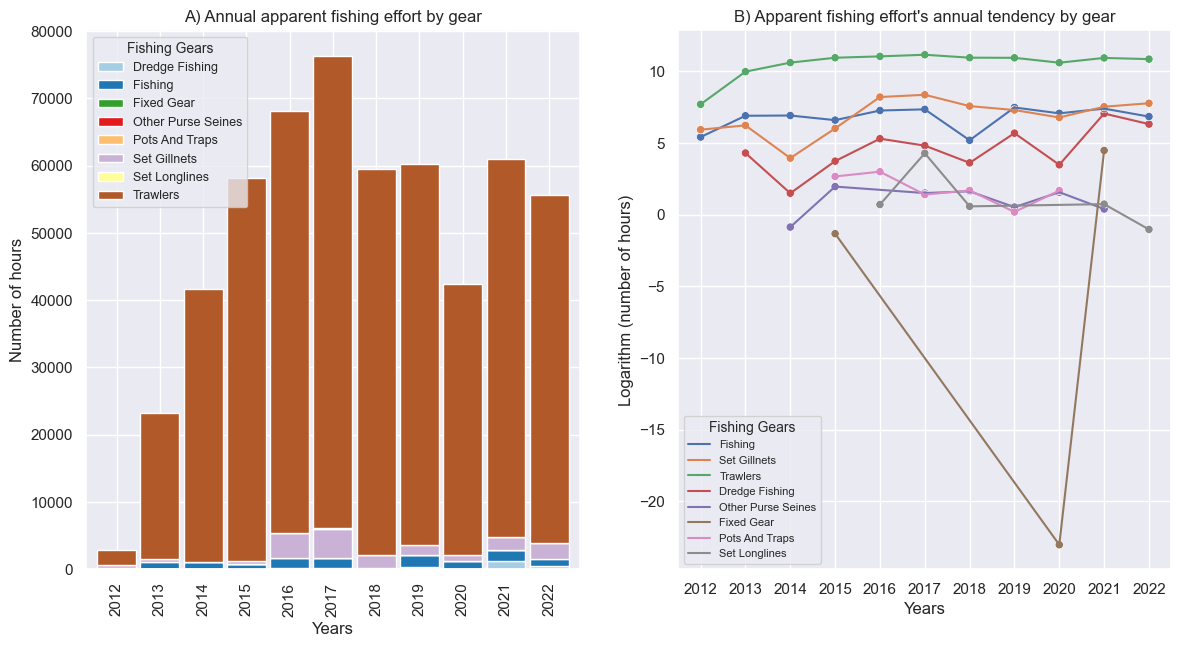

In [459]:
# Common values of visual features
legend_title_fontsize = 10
legend_fontsize = 9
geartype_legend_length = len(set(timeseries['geartype']))

_, ax =plt.subplots(nrows=1, ncols=2, figsize=(14,7))
stack_barplot_df.plot (kind = 'bar', stacked = True, width=0.9, colormap='Paired', ax = ax[0])


# All fishing gear tendendencies
sns.scatterplot(data=scatter_line_plot_df, 
                x = "date", 
                y ="hours",
                hue='geartype', 
                ax = ax[1])
sns.lineplot(data=scatter_line_plot_df, 
                x = "date", 
                y="hours",
                hue='geartype', 
             ax = ax[1])

# Legend of different facegrid quadrants 
# ----> [0,0]
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=labels, title = "Fishing Gears", title_fontsize = legend_title_fontsize, fontsize = legend_fontsize)
ax[0].set_title("A) Annual apparent fishing effort by gear")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Number of hours")

# ----> [0,1]
handles, labels = ax[1].get_legend_handles_labels()
handles = handles[geartype_legend_length:]
ax[1].legend(handles=handles, labels=labels, title = "Fishing Gears", title_fontsize = 10, fontsize = 8)
ax[1].set_title("B) Apparent fishing effort's annual tendency by gear")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Logarithm (number of hours)")

In [577]:
# Create polygon vector (heatmap) for trawling in the area for the whole series
timeseries ['cell'] = timeseries.groupby(['lon', 'lat'], sort=True).ngroup() + 1

# Split the dataset between periods of fishing before and after MPA restriction
fishing_2012_2015 = [str(2012 + x) for x in range(4)]
fishing_2016_2021 = [str(2016 + x) for x in range(6)]

# Slice data into fishing periods
trawling_before = timeseries.loc [timeseries['date'].isin(fishing_2012_2015)]
dredging_before = trawling_before.copy()
trawling_after = timeseries.loc [timeseries['date'].isin(fishing_2016_2021)]
dredging_after = trawling_after.copy()
trawling_2022 = timeseries.loc [timeseries['date'] == '2022']
dredging_2022 = trawling_2022.copy()

# Calculate apparent fishing effort for each period
yearly_total_trawling = create_total_fishing_effort(timeseries, 'trawlers')
yearly_total_dredging = create_total_fishing_effort(timeseries, 'dredge_fishing')
trawling_before_map = create_total_fishing_effort(trawling_before, 'trawlers')
trawling_after_map = create_total_fishing_effort(trawling_after, 'trawlers')
dredging_before_map = create_total_fishing_effort(dredging_before, 'dredge_fishing')
dredging_after_map = create_total_fishing_effort(dredging_after, 'dredge_fishing')
trawling_22_map = create_total_fishing_effort(trawling_2022, 'trawlers')
dredging_22_map = create_total_fishing_effort(dredging_2022, 'dredge_fishing')

# Create geomap of the apparent fishing effort 
geo_yearly_total_trawling = build_polygon_vector(yearly_total_trawling, CELL_SIZE_DEGREE)
geo_yearly_total_dredging = build_polygon_vector(yearly_total_dredging, CELL_SIZE_DEGREE)
geo_trawling_before_map = build_polygon_vector(trawling_before_map, CELL_SIZE_DEGREE)
geo_trawling_after_map = build_polygon_vector(trawling_after_map, CELL_SIZE_DEGREE)
geo_dredging_before_map = build_polygon_vector(dredging_before_map, CELL_SIZE_DEGREE)
geo_dredging_after_map = build_polygon_vector(dredging_after_map, CELL_SIZE_DEGREE)
geo_trawling_22_map = build_polygon_vector(trawling_22_map, CELL_SIZE_DEGREE)
geo_dredging_22_map = build_polygon_vector(dredging_22_map, CELL_SIZE_DEGREE)


### 3.2 Spatial analysis of overall fishing effort 


Tiles 24, 25, 35, 46, 57 and 58 are mainly covering the area of the South Arran MPAs which has implemented various degrees of fishing bans, chiefly on trawling and dredging (Fig. 3). The data showed that most of the trawling was done around the and at the outskirts of this MPA, with tiles 24, 25, 45 and 57 accumulating 20,000 or more hours each from 2012 to 2022. However the entire area has been swept to some extent with those near shore being disturbed the least. The total accumulated hours for the entire area since 2012 to 2022 is ~517,000 hours, an average of ~129 hours per day when taking the whole year and across 90 tiles. The average would be much higher when taking only the days vessels are allowed to fish. The swept areas around the MPA received a 5h a day of fishing effort each, that is 3.6 min/km2.

<img src='../images/timeseries_trawling_map.png'/>

**Fig. 5. Overall trawling fishing effort from 2012-2016**. The Scotland map is outlined in blue while in red are the MPAs. The apparent effort was grouped within bands of hours so that tiles were coloured according to band they belonged to. Yellow tiles showed the areas that received the most effort while purple the least. Those in between showed a gradual decrease.

Conversely, dredging has accumulated only 0.4% of all fishing effort (>2,500 hours), focussing more in the southwest region between the coast and the South Arran MPA, northeast between the South Arran MPA and the coast and nearby the coastline in general (Fig. 6). The total swept area is also much smaller than trawling (54 tiles).

<img src='../images/timeseries_dredging_map.png'/>

**Fig. 6. Overall dredge-fishing effort from 2012-2016**. The Scotland map is outlined in blue while in red are the MPAs. The apparent effort was grouped within bands of hours so that tiles were coloured according to band they belonged to. Yellow tiles showed the areas that received the most effort while purple the least. Those in between showed a gradual decrease.


### 3.3 Spatial analysis of the fishing effort at different periods

The trawling fishing effort from 2012 to 2015 showed that most areas within the South Arran MPA were swept. For the period 2016-2021 tile 47 on the northeast of the island and outside the MPA boundaries was not fished. Until then, tile 36 that encompasses the rivers Clauchan Water and Machrie Water within the island were somehow swept although the total accumulated hours in 11 years is only 18 hours (below C, E). Then in 2022 36 was no longer fished but tile 47 was, but yet again, a negligible 8 hours across the whole period (below, G).

On the other hand, dredging for the 2012-2015 period was confined to the south of the region well away from the South Arran MPA (below, D). From then after, dredging expanded to the north and within the MPA (below F, H). Although from those tiles well within the MPA (24, 35, 46 and 57) the fishing effort is more significat within 24 to the east of the MPA.

Text(718.1931818181816, 0.5, 'Latitude (Degrees)')

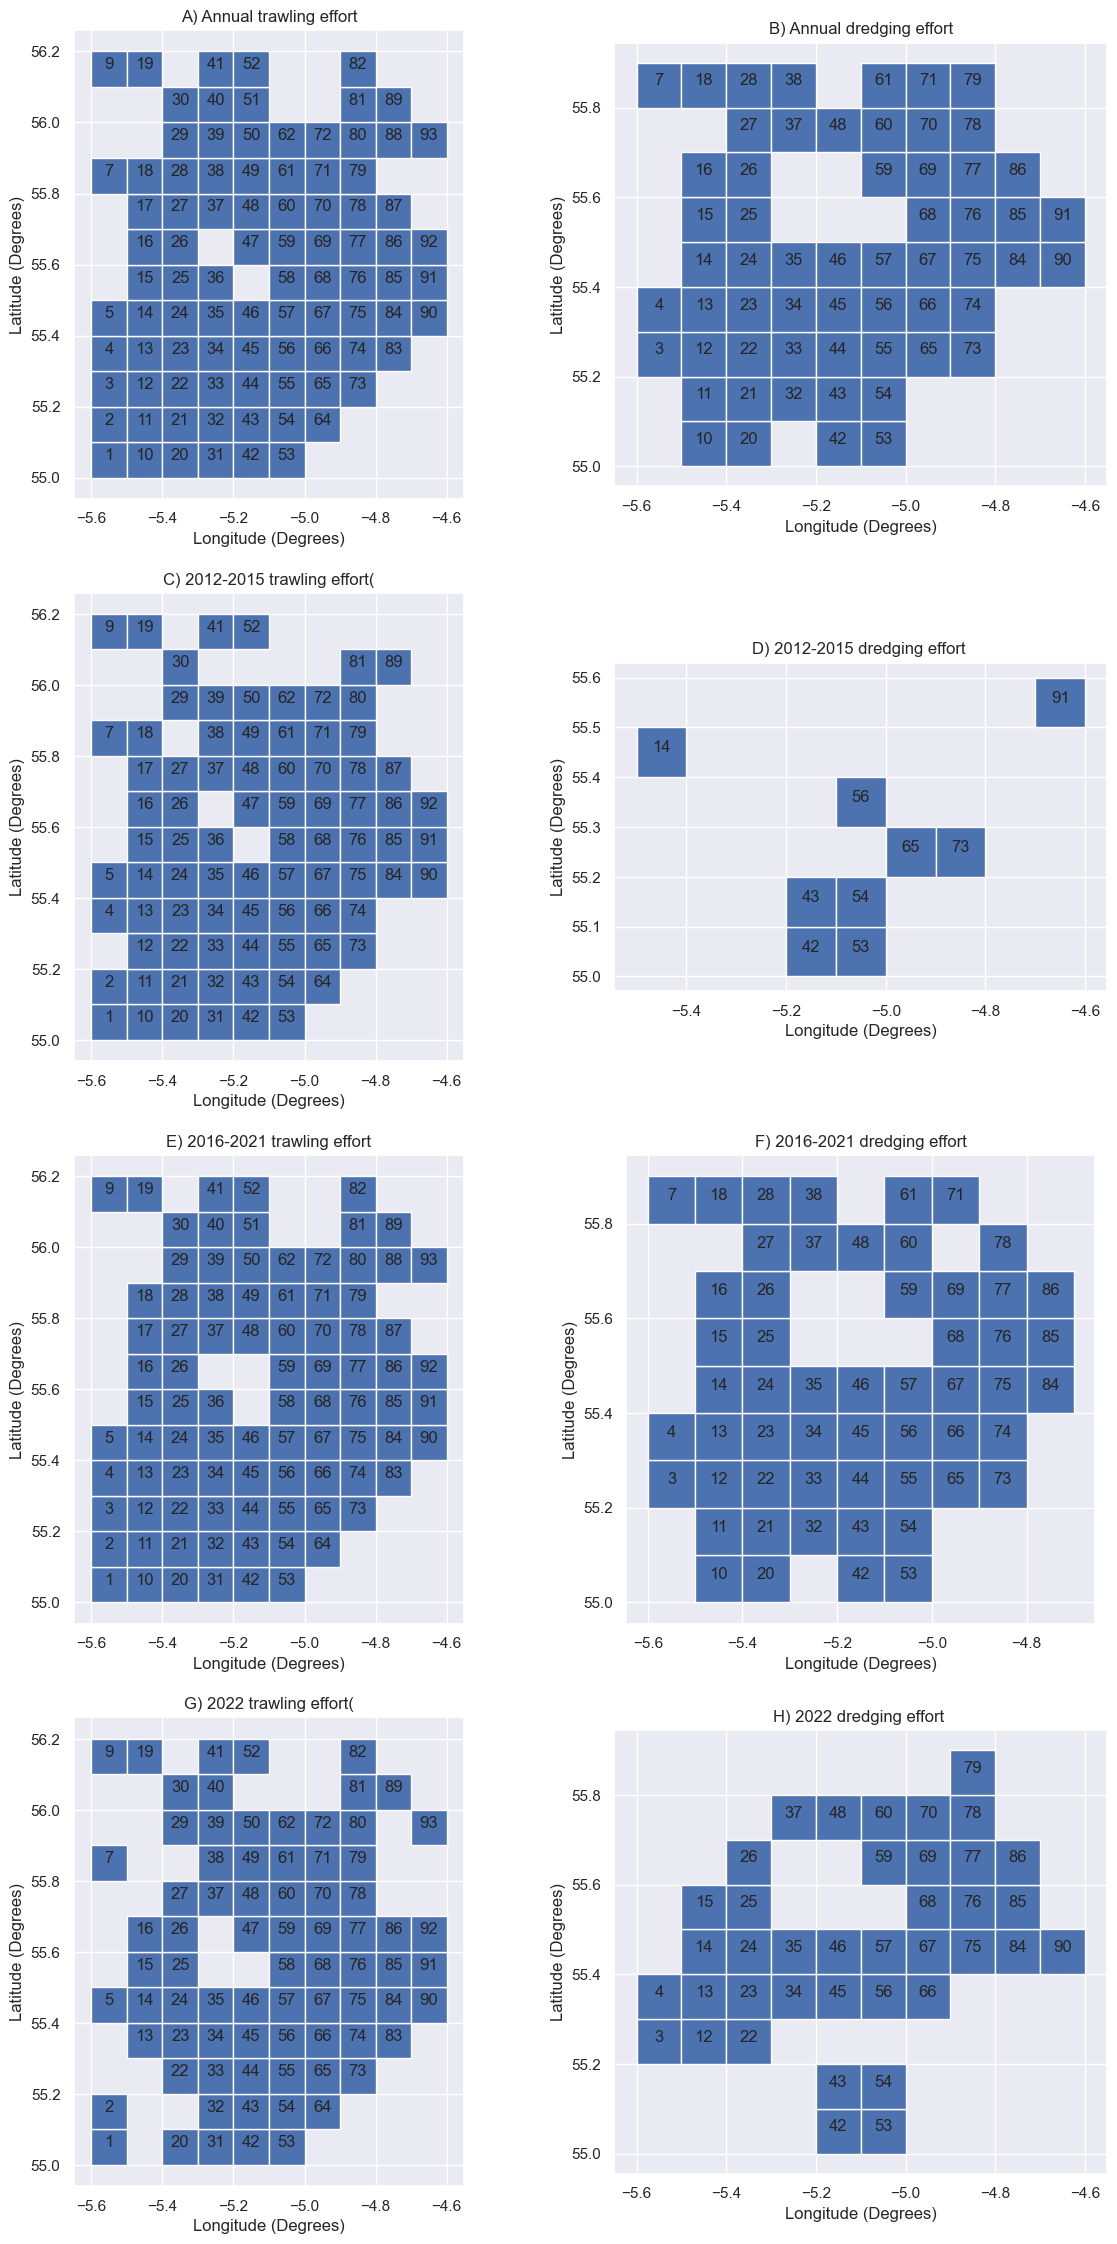

In [582]:
_, ax =plt.subplots(nrows=4, ncols=2, figsize=(14,28))

# First row
geo_yearly_total_trawling.plot(ax = ax[0][0])
draw_polygon_ids(geo_yearly_total_trawling, ax[0][0])
geo_yearly_total_dredging.plot(ax = ax[0][1])
draw_polygon_ids(geo_yearly_total_dredging, ax[0][1])

# Second row
geo_trawling_before_map.plot(ax = ax[1][0])
draw_polygon_ids(geo_trawling_before_map, ax[1][0])
geo_dredging_before_map.plot(ax = ax[1][1])
draw_polygon_ids(geo_dredging_before_map, ax[1][1])

# Third row
geo_trawling_after_map.plot(ax = ax[2][0])
draw_polygon_ids(geo_trawling_after_map, ax[2][0])
geo_dredging_after_map.plot(ax = ax[2][1])
draw_polygon_ids(geo_dredging_after_map, ax[2][1])

# Fourth row
geo_trawling_22_map.plot(ax = ax[3][0])
draw_polygon_ids(geo_trawling_22_map, ax[3][0])
geo_dredging_22_map.plot(ax = ax[3][1])
draw_polygon_ids(geo_dredging_22_map, ax[3][1])

ax[0][0].set_title("A) Annual trawling effort")
ax[0][0].set_xlabel("Longitude (Degrees)")
ax[0][0].set_ylabel("Latitude (Degrees)")

ax[0][1].set_title("B) Annual dredging effort")
ax[0][1].set_xlabel("Longitude (Degrees)")
ax[0][1].set_ylabel("Latitude (Degrees)")

ax[1][0].set_title("C) 2012-2015 trawling effort")
ax[1][0].set_xlabel("Longitude (Degrees)")
ax[1][0].set_ylabel("Latitude (Degrees)")

ax[1][1].set_title("D) 2012-2015 dredging effort ")
ax[1][1].set_xlabel("Longitude (Degrees)")
ax[1][1].set_ylabel("Latitude (Degrees)")

ax[2][0].set_title("E) 2016-2021 trawling effort")
ax[2][0].set_xlabel("Longitude (Degrees)")
ax[2][0].set_ylabel("Latitude (Degrees)")

ax[2][1].set_title("F) 2016-2021 dredging effort")
ax[2][1].set_xlabel("Longitude (Degrees)")
ax[2][1].set_ylabel("Latitude (Degrees)")

ax[3][0].set_title("G) 2022 trawling effort(")
ax[3][0].set_xlabel("Longitude (Degrees)")
ax[3][0].set_ylabel("Latitude (Degrees)")

ax[3][1].set_title("H) 2022 dredging effort ")
ax[3][1].set_xlabel("Longitude (Degrees)")
ax[3][1].set_ylabel("Latitude (Degrees)")

In [583]:
geo_yearly_total_trawling.to_csv(FIRTH_DATA_PATH / 'trawling_total_by_cell.csv', index=False)
geo_yearly_total_dredging.to_csv(FIRTH_DATA_PATH / 'dredging_total_by_cell.csv', index=False)

## 4. Discussion

This study showed that trawling is overwhelmingly the fishing gear more widely used, both in terms of space and time. Trawling most notably occurred in a semicircle that goes from the east to the west around the South Arran MPA and prolongs to the north. One of the reasons may well be the known effect that MPAs have in their surroundings, where species within the no-take zone proliferate migrating out of the boundaries as they compete for the limiting resources. Also eggs and larvae drifting out of the MPAs may be another one[14]. Fishermen may see this  as an opportunity and tend to fish just outside and around their boundaries to catch the spillovers. However, fisheries statistics showed that most of the fishing taking place in the Clyde sea is for Norway lobster and other shellfish, such as scallops [2]. Norway lobster are found to have great site fidelity and very short home range (< 736m2) so the mobility aspect outside the boundaries, in this case, may not be the reason[15]. Additionally, other studies on the European lobster(_Homarus gammarus_) with larger home ranges, up to 0.65km2, showed an increase of biomass of 225% within the no-take zone while outside it was much less significant, with some places showing up to 19%[16].

Probably a more realistic reason why trawling occurs around MPA and up is because the seabed there is mosly composed of mudflats, perfect suitable habitats for the Norway lobster as shown by its distribution (Fig. 1) and the seabed habitat mapping (Fig. 2). This combination of soft bottom habitats and fished species makes demersal-trawling the best choice for commercial fisheries in the area.

The data also showed that some trawling effort is occurring within the boundaries of the South Arran MPA, even after 2016 when restricted bans were implemented [17]. Fishing on tile 57 is explained by the fact that its area covers parts of the MPA where demersal-trawling, under certain conditions, is allowed. The same case is for all tiles that somehow touches these trawling-permitted areas (Fig. 6, Fig. 15). Tiles 35 and 45 are almost entirely within the ban-fishing zone of the MPA but are touching tiles 34 and 44 where demersal trawling is accepted. The data does not have enough resoultion to conclude wether the negligible hours of trawling in 35 and 45 are due to illegal fishing or because their boundaries are very fuzzy. For example, vessels fishing at the boundaries of 34 and 44, due to usual 20m GPS errors could be placed in tiles 35 and 45. The fact that the latter exhibited a low number of hours may indicate that it's the case of a data-like error. In order to understand better what the exact case is, a zoom-in search in that particular are should be done. This is still possible through GFW API which provides retrieval of data for tiles of very high resolution (0.01 x 0.01 degrees).

As for dredging most of this activity occurs on the western side of the Island of Arran, northen part of the Firth of Clyde and at some places close the coastline (Fig. 6). The reason being that in those areas more sandy and gravelly seabed habitats are found, which are more suitable for this species [18], as shown by the greenish areas of the habitat classification map (Fig. 2). Similarly to trawling, there are dredging records in the tiles within the MPA although yet again the accumulated hours are very small. The fuzzy boundaries among neighbouring tiles may be the reason why the analysed data shows interferneces with the banned zones.  

<img src='../images/ssi_20150437_en_001.jpg'/>

**Fig. 15. Illustrative map showing the South Arran MPA, and those parts of the MPA in respect of which the Order makes provision."** [13]. Map of the South Arran MPA and areas where certain fishing gears are prohibited. There are four zones: in red to the west a no-take zone; orange strips to the south forbid demersal trawling and dredging (i.e., fishing on scallops using beam trawlers); to the south and south east of the MPA blue strips forbid trawling and creel fishing (pots and traps); At the outer edges of all around the MPA dredging is not allowed, howe dermersal trawling may occur.



## References
1. Fishing [Internet]. Fishing | Scotland's Marine Assessment 2020. 2012 [cited 2023Mar20]. Available from: https://marine.gov.scot/sma/assessment/fishing 

2. The Scottish Government. Scottish Sea Fisheries Statistics 2019 [Internet]. Scottish Government. The Scottish Government; 2020 [cited 2023Mar20]. Available from: https://www.gov.scot/publications/scottish-sea-fisheries-statistics-2019/pages/11/ 

3. Clyde SMR [Internet]. Clyde SMR | Scotland's Marine Assessment 2020. [cited 2023Mar20]. Available from: https://marine.gov.scot/sma/region/clyde-smr 

4. Team GN. Scottish Spatial Data Infrastructure [Internet]. SpatialData.gov.scot. 2007 [cited 2023Mar20]. Available from: https://www.spatialdata.gov.scot/geonetwork/srv/eng/catalog.search;jsessionid=031FD9D529A0636FDB129D0BB0E126BD#/metadata/Marine_Scotland_FishDAC_874 

5. The process of developing a seabed habitat map for the firth of clyde [Internet]. [cited 2023Mar20]. Available from: https://www.clydemarineplan.scot/wp-content/uploads/2016/06/The-process-of-developing-a-seabed-habitat-map-for-the-Firth-of-Clyde.pdf 

6. Burrowed mud [Internet]. NatureScot. [cited 2023Mar20]. Available from: https://www.nature.scot/landscapes-and-habitats/habitat-types/coast-and-seas/marine-habitats/burrowed-mud 

7. Maerl beds [Internet]. NatureScot. [cited 2023Mar20]. Available from: https://www.nature.scot/landscapes-and-habitats/habitat-types/coast-and-seas/marine-habitats/maerl-beds

8. Flame shell beds [Internet]. NatureScot. [cited 2023Mar20]. Available from: https://www.nature.scot/landscapes-and-habitats/habitat-types/coast-and-seas/marine-habitats/flame-shell-beds 

9.  Introduction [Internet]. Global Fishing Watch API Documentation. [cited 2023Mar20]. Available from: https://globalfishingwatch.org/our-apis/documentation#create-a-report-of-a-specified-region 

10. Global fishing watch: Data download portal [Internet]. Global Fishing Watch | Data download portal. [cited 2023Mar20]. Available from: https://globalfishingwatch.org/data-download/datasets/public-fishing-effort 

11. Countries (December 2022) GB BFC [Internet]. Open Geography Portal. [cited 2023Mar21]. Available from: https://geoportal.statistics.gov.uk/datasets/ons::countries-december-2022-gb-bfc/explore?location=55.391899%2C-2.950000%2C6.85 

12. Team GN. Scottish Spatial Data Infrastructure [Internet]. SpatialData.gov.scot. 2007 [cited 2023Mar21]. Available from: https://www.spatialdata.gov.scot/geonetwork/srv/eng/catalog.search;jsessionid=031FD9D529A0636FDB129D0BB0E126BD#/metadata/Marine_Scotland_FishDAC_1306 

13. Compliance for the south arran marine protected area: The K.I.P ... - coast [Internet]. [cited 2023Mar21]. Available from: https://www.arrancoast.com/wp-content/uploads/2019/01/KIPPERArranCoast-Dec-18-Update.pdf  

14. Lenihan HS, Gallagher JP, Peters JR, Stier AC, Hofmeister JK, Reed DC. Evidence that spillover from marine protected areas benefits the spiny lobster (panulirus interruptus) fishery in Southern California. Scientific Reports. 2021;11(1).   

15. Vigo M, Navarro J, Masmitja I, Aguzzi J, García JA, Rotllant G, et al. Spatial ecology of Norway lobster nephrops norvegicus in Mediterranean deep-water environments: Implications for designing no-take marine reserves. Marine Ecology Progress Series. 2021;674:173–88.  

16. Wiig JR, Moland E, Haugen TO, Olsen EM. Spatially structured interactions between lobsters and lobster fishers in a coastal habitat: Fine-scale behaviour and survival estimated from acoustic telemetry. Canadian Journal of Fisheries and Aquatic Sciences. 2013;70(10):1468–76. 

17. The south arran marine conservation order 2015 [Internet]. Legislation.gov.uk. Queen's Printer for Scotland; [cited 2023Mar21]. Available from: https://www.legislation.gov.uk/ssi/2015/437/made 

18. Evidence [Internet]. Open Seas. [cited 2023Mar21]. Available from: https://www.openseas.org.uk/evidence/ 